<h1>Accident detection using CNN image classification</h1> 



<h2>Mouting Google drive</h2>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking avaiable GPU

In [2]:
!nvidia-smi

Sat Apr 30 14:23:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Confirming the prescence of GPU

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Setting parameters for the model

In [4]:
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.show()

%load_ext autoreload
%autoreload 2

np.random.seed(1)

Importing all the necessary libraries

In [5]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Checking directories

In [6]:
os.listdir('/content/drive/MyDrive/dataforai/train')

['accident', 'noaccident']

In [7]:
os.listdir('/content/drive/MyDrive/dataforai/test')

['accident', 'noaccident']

Assigning variables for datasets<br>
train_dir = train directory of the dataset<br>
test_dir = test directory of the dataset

In [8]:
train_dir = "/content/drive/MyDrive/dataforai/train/"
test_dir  = "/content/drive/MyDrive/dataforai/test/"
categories = ['Accident','Noaccident']
train_dir
# test_dir

'/content/drive/MyDrive/dataforai/train/'

Initializing batch_size, image height and width

In [9]:
batch_size = 32
img_height = 256
img_width = 256

Preprocessing all the Image data from test dataset<br>
Using label as inferred since the dataset is binary class classification<br>
Color channel of RGB<br>


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=True,
  )

Found 382 files belonging to 2 classes.



Preprocessing all the Image data from train dataset<br>
Using label as inferred since the dataset is binary class classification<br>
Color channel of RGB<br>


In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
   train_dir,
   labels = 'inferred',
   class_names = None,
   color_mode = 'rgb',
   batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    crop_to_aspect_ratio=True,
)

Found 1302 files belonging to 2 classes.


<h4> Total images to process </h4><br>
Training image = 1302 belonging to 2 classes i.e accident and no accident <br>
Test/validation image = 382 belonging to 2 classes i.e accident and no accident

In [12]:
class_names = train_ds.class_names
print(class_names)

['accident', 'noaccident']


Lets plot some of the images from dataset with their labels

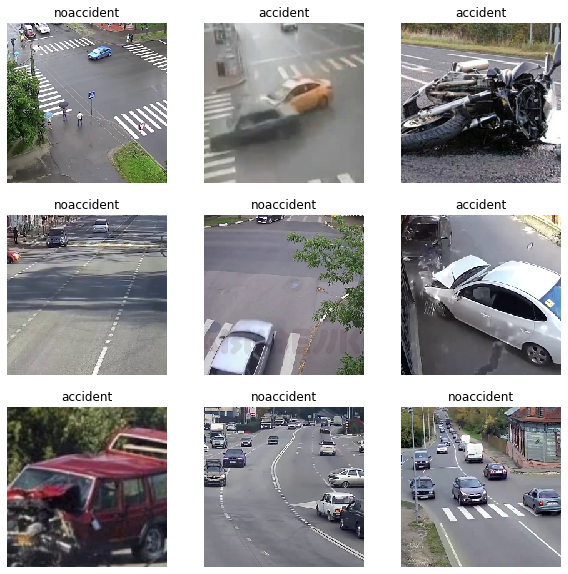

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


<h3>Creating convolution layers</h3> <br>
Rescaling images by ./255 and channelling to 3 (rgb) with image height of 256 and image width of 256 <br>
Conv2D of different hidden layers/ hyperparameter is used along with padding same<br>
Relu is taken for Activation function for the model <br>
Maxpooling for compressing the image<br>
Finally the images are flattened and densed 


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Here adam is assigned as a optimizer with the learning rate of 1e-3 <br>
Loss as a binary cross entropy
Metrics for evaluation as BinaryAccuracy and falsenegatives

In [16]:
his = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])

To evaluate furthermore loss of Sparse Categorical cross entropy is taken<br>
And metrics as Accuracy

In [17]:
his_model = model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Finally the summary of the model is printed

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

<h3> Model summary</h3><br>
Use of 3 convolution layers<br> trainable parameters of the model = 8,412,578


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h1> Model training</h1>

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10
41/41 [==============================] - 263s 6s/step - loss: 0.7699 - accuracy: 0.6697 - val_loss: 1.4329 - val_accuracy: 0.3141
Epoch 2/10
41/41 [==============================] - 13s 288ms/step - loss: 0.4437 - accuracy: 0.7711 - val_loss: 1.5333 - val_accuracy: 0.2199
Epoch 3/10
41/41 [==============================] - 13s 276ms/step - loss: 0.3465 - accuracy: 0.8303 - val_loss: 2.9101 - val_accuracy: 0.2853
Epoch 4/10
41/41 [==============================] - 13s 275ms/step - loss: 0.2855 - accuracy: 0.8733 - val_loss: 3.7847 - val_accuracy: 0.2932
Epoch 5/10
41/41 [==============================] - 13s 283ms/step - loss: 0.2475 - accuracy: 0.8833 - val_loss: 3.4010 - val_accuracy: 0.2880
Epoch 6/10
41/41 [==============================] - 13s 276ms/step - loss: 0.2014 - accuracy: 0.9040 - val_loss: 5.6273 - val_accuracy: 0.3141
Epoch 7/10
41/41 [==============================] - 13s 274ms/step - loss: 0.1697 - accuracy: 0.9309 - val_loss: 8.6461 - val_accuracy: 0.3194
E

Training the model with 10 epochs

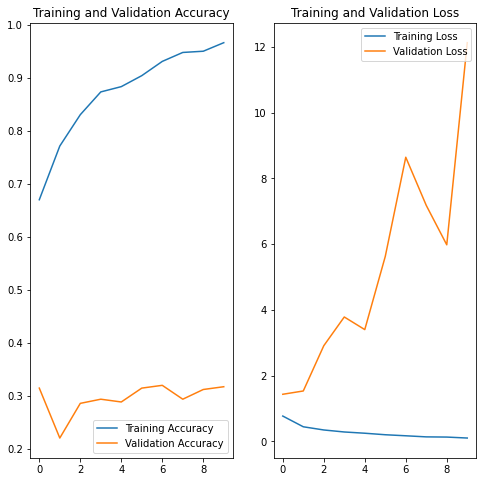

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h3> Findings</h3> <br>
As the model is trained with 10 epoch there is noticable disrepancy in the training and validation ratio.<br>
There is drastic different between training loss and validation loss<br>
Such condition is <b>overfitting condition</b> and our model has over fitted

To reduce <b>overfitting</b> we use <b>data augmentation</b> with <b>dropout</b> to our model

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Data augmentation rotates the images from training dataset and randomly rotate/zoom for better understanding of the image<br>
An example is plotted below

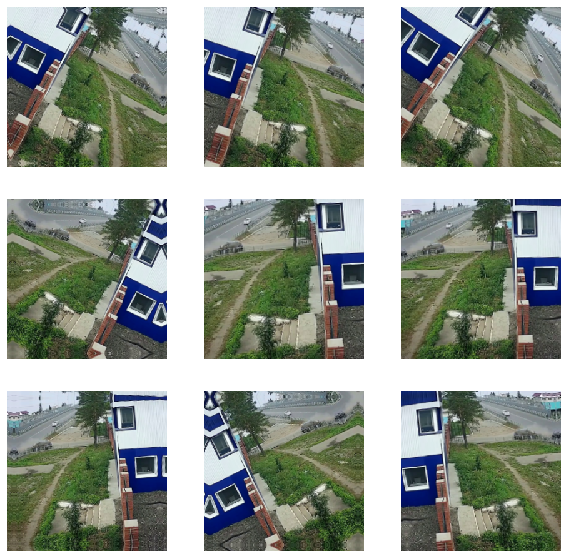

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

<h2> Training model after data augmentation</h2>

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

We have just added dropout to our layer to train from every perspectives of the image <br>
Model is now trained with <b> 15 epochs

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
41/41 [==============================] - 15s 291ms/step - loss: 0.8243 - accuracy: 0.6321 - val_loss: 1.3076 - val_accuracy: 0.3272
Epoch 2/15
41/41 [==============================] - 13s 290ms/step - loss: 0.5128 - accuracy: 0.6874 - val_loss: 1.3058 - val_accuracy: 0.2644
Epoch 3/15
41/41 [==============================] - 13s 284ms/step - loss: 0.4803 - accuracy: 0.7235 - val_loss: 2.2819 - val_accuracy: 0.2330
Epoch 4/15
41/41 [==============================] - 13s 286ms/step - loss: 0.4634 - accuracy: 0.7412 - val_loss: 2.2971 - val_accuracy: 0.2173
Epoch 5/15
41/41 [==============================] - 13s 291ms/step - loss: 0.4511 - accuracy: 0.7604 - val_loss: 1.3898 - val_accuracy: 0.1728
Epoch 6/15
41/41 [==============================] - 13s 286ms/step - loss: 0.4453 - accuracy: 0.7527 - val_loss: 1.8166 - val_accuracy: 0.1832
Epoch 7/15
41/41 [==============================] - 13s 287ms/step - loss: 0.4527 - accuracy: 0.7581 - val_loss: 1.7336 - val_accuracy: 0.2408

<h2> Plotting new graph

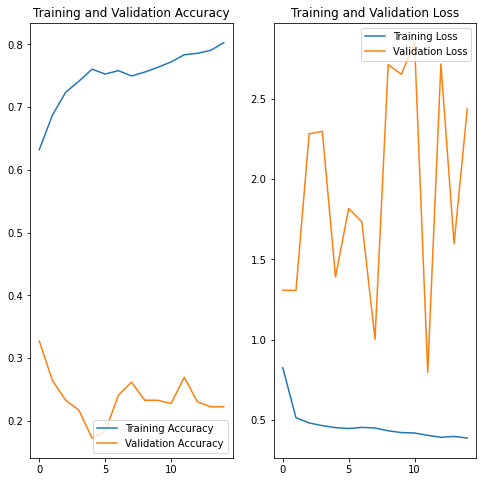

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is difference between the two lines, but it has significantly decreased as the layer receives data augmentation which has reduce the cause of over fitting of the model.

<h1> Testing with images

This image most likely belongs to accident with a 100.00 percent confidence.


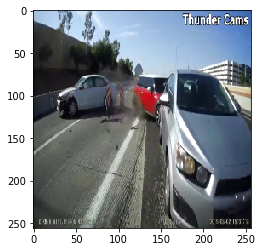

In [32]:
image = "/content/drive/MyDrive/AccidentDataset/test/accident/11730.png"

img = tf.keras.utils.load_img(
    image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print( "This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
plt.imshow(img)

<h1> Exporting the model

In [33]:
import pickle

In [34]:
import pickle
modelname = "accident"
pickle.dump(model,open(modelname,"wb"))

INFO:tensorflow:Assets written to: ram://b814ee33-3151-4eb6-8c98-fc85fab764a8/assets


<h1> Conclusion

Accident detection is binary class classification of the images which uses CNN for model building and feature extractions. First part of the documention we only used raw data which are only proessed according to the provided data. despite there is limited data to train the model it has showed a good amount of accuracy of 80% these are well tested after the model building. Such system can be used to solve problem of detecting anamolies in the road situations. This project has taught us a gratitude of knowledge to kick start the vision towards learning neural networks.